# Generative Model for SVHN Image and Label Synthesis

The objective of this hackathon is to develop a generative model capable of creating high-quality Street View House Numbers (SVHN) images along with corresponding accurate labels. Your generative model output will be used as the input data for a fixed classifier training. The best performing classifier wins the hackathon. Participants are required to submit a model checkpoint and two Colab notebooks—one for training and the other for model evaluation. The evaluation notebook can be found [here](https://colab.research.google.com/drive/1Fppb25hJJiYhcbx4zZby-XScdFR32IhF?usp=sharing).

## Tasks
- **Model Definition:** Define a generative model capable of producing samples from the SVHN data distribution, conditioned on a class label. These synthetic images will serve as input data for training the classifier during the evaluation phase.
- **Training:** Train your generative model using the SVHN dataset, ensuring high quality and diversity in the generated samples.
- **Model Checkpoint:** Save the weights of your trained generative model for evaluation and  submission.


## Evaluation Criteria

The generator models are evaluated by training a fixed classifier on their generated data, and measuring the classifier performance on an evaluation dataset. You can not modify the classifier or its training. The classifier is trained with 3 seeds. The 3 seeds are going to be changed for the final evaluation and the leaderboard to avoid overfitting to these seeds.

## Constraints

- **Data:** Participants are prohibited from loading any external data except the SVHN training set.
- **Model:**  
 - Participants are prohibited from loading pre-trained (not trained by you) models.
 - The model needs to be able to generate samples that are not present in the training dataset.
 - The model has to be a generative model and cannot store any training samples.
 - Model output should depend on random noise.
- **Compute:**  Model can generate 1000 samples within 3 seconds on the snowflake cluster or colab, using a maximum of 10GB of GPU memory.
-**Collaboration:** All teams must have individual slutions, and can not collaborate with other teams.

## Submission

The submission needs to include the following files:

- **Model Checkpoint:** Participants must provide a model checkpoint containing the trained generative model.

- **Training Notebook:** A Colab notebook exclusively for training the generative model. Participants should include preprocessing steps, model definition, and training procedures.

- **Evaluation Notebook:** The notebook designated for model evaluation. It should contain the model definition and the generate function, as specified in the evaluation notebook.

Zip the 3 files, rename it to the last name of all team members (in lowercase separated by underscores) and
[submit it here](https://polybox.ethz.ch/index.php/s/p2BVHpyExJErKu4).
So a team of Harry Potter, Hermione Granger and Ron Weasley would submit the zip file `potter_granger_weasley.zip`

**Now go an read the evaluation notebook!**

In [1]:
team_members = ['Ming-Han Lee', 'Chia-Wen Chen']
assert len(team_members) > 0

### Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from itertools import islice
from tqdm import tqdm
import pickle
import torch
from torchvision import transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import time
from google.colab import drive

In [2]:
import torchvision.utils as vutils
from torch import optim

### Load training data

In [3]:
torch.cuda.is_available()

True

In [6]:
BATCH_SIZE = 1024
Z_DIM = 10
LABEL_EMBED_SIZE = 5
NUM_CLASSES = 10
IMGS_TO_DISPLAY_PER_CLASS = 20
LOAD_MODEL = False
CHANNELS = 3
EPOCHS = 100

In [7]:
transform = transforms.ToTensor()
# transform = transforms.Compose([
#      transforms.Grayscale(num_output_channels=3),
#      transforms.ToTensor(),
#      transforms.Normalize(
#          mean=[0.485],
#          std=[0.229]
#      ),
# ])
train_dataset = SVHN(root='~/datasets', split='train', transform=transform, download=True)
data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 182040794/182040794 [00:17<00:00, 10584541.59it/s]


In [8]:
samples_path = os.path.join('./samples', 'SVHN')
os.makedirs(samples_path, exist_ok=True)

In [9]:
def generate_imgs(z, fixed_label, epoch=0):
    gen.eval()
    fake_imgs = gen(z, fixed_label)
    fake_imgs = (fake_imgs + 1) / 2
    fake_imgs_ = vutils.make_grid(fake_imgs, normalize=False, nrow=IMGS_TO_DISPLAY_PER_CLASS)
    vutils.save_image(fake_imgs_, os.path.join(samples_path, 'sample_' + str(epoch) + '.png'))

In [10]:
# Networks
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)

### Visualize data

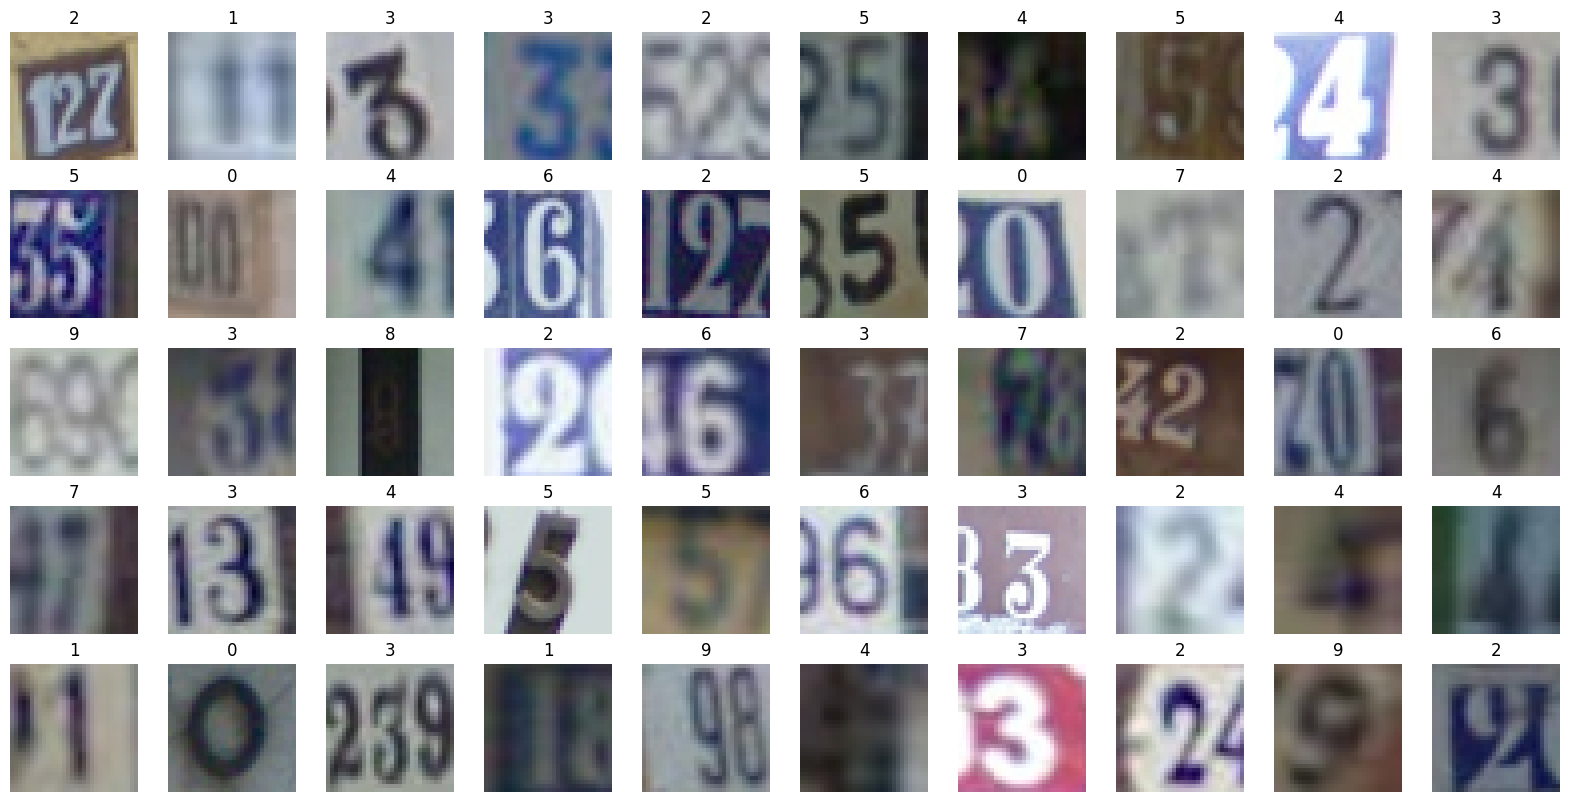

In [11]:
def plot_samples(images, labels):

    fig = plt.figure(figsize=(20, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.3)

    for ax, im, label in zip(grid, images, labels):
        im = im.permute(1, 2, 0)
        im = im.detach().cpu().numpy()
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'{label}')

    plt.show()

num_samples = 50
random_idxs = np.random.choice(np.arange(len(train_dataset)), size=num_samples, replace=False)

images = [train_dataset[i][0] for i in random_idxs]
labels = [train_dataset[i][1] for i in random_idxs]

plot_samples(images, labels)

### Helper functions to save and load models

In [13]:
checkpoint_path = '/content/gdrive/MyDrive/hodl/'

def save_checkpoint(model, optimizer, epoch, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    checkpoint_filename = f'checkpoint_epoch_{epoch}.pth'
    checkpoint_filepath = checkpoint_path + checkpoint_filename
    torch.save(checkpoint, checkpoint_filepath)
    print(f"Checkpoint saved at: {checkpoint_filepath}")


def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from: {checkpoint_path}")
    return model, optimizer, epoch, loss

start_epoch = 0

Mounted at /content/gdrive


In [32]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=10, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, pad=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv4 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat((x, label_embed), dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = torch.tanh(self.tconv4(x))
        return x

    def generate(self, n_samples=1000, device=device):
        labels = torch.randint(0, self.num_classes, (n_samples,)).to(device)
        z_fake = torch.randn((n_samples, self.z_dim), dtype=torch.float).to(device)
        fake_imgs = self.forward(z_fake, labels)
        fake_imgs = (fake_imgs + 1) / 2

        return fake_imgs, labels


class Discriminator(nn.Module):
    def __init__(self, num_classes=10, channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.image_size = 32
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        self.conv1 = conv_block(channels + 1, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, 1, k_size=4, stride=1, pad=0, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        alpha = 0.2
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = torch.sigmoid(self.conv4(x))
        return x.squeeze()

In [15]:
gen = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS).to(device)
dis = Discriminator(num_classes=NUM_CLASSES, channels=CHANNELS).to(device)

In [20]:
model_path = ''
if model_path:
    os.makedirs(model_path, exist_ok=True)

In [16]:
# Model Summary
print("------------------Generator------------------")
print(gen)
print("------------------Discriminator------------------")
print(dis)

------------------Generator------------------
Generator(
  (label_embedding): Embedding(10, 5)
  (tconv1): Sequential(
    (0): ConvTranspose2d(15, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
------------------Discriminator------------------
Discriminator(
  (label_embedding): Embedding(10, 1024)
  (conv1): Sequential(
    (0): Conv2d(4, 64, kernel_size

In [17]:
# Define Optimizers
g_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
d_opt = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)

In [18]:
loss_fn = nn.BCELoss()

In [19]:
# Fix images for viz
fixed_z = torch.randn(IMGS_TO_DISPLAY_PER_CLASS*NUM_CLASSES, Z_DIM).to(device)
fixed_label = torch.arange(0, NUM_CLASSES)
fixed_label = torch.repeat_interleave(fixed_label, IMGS_TO_DISPLAY_PER_CLASS).to(device)

total_iters = 0
max_iter = len(data_loader)

In [21]:
# Training
for epoch in range(EPOCHS):
    gen.train()
    dis.train()

    for i, data in enumerate(data_loader):

        total_iters += 1

        # Loading data
        x_real, x_label = data

        # Input size for this batch
        input_size = x_real.size(0)
        z_fake = torch.randn(input_size, Z_DIM)

        x_real = x_real.to(device)
        x_label = x_label.to(device)
        z_fake = z_fake.to(device)

        # Generate fake data
        x_fake = gen(z_fake, x_label)

        # Train Discriminator

        fake_out = dis(x_fake.detach(), x_label)
        real_out = dis(x_real.detach(), x_label)

        # Labels
        real_label = torch.ones(input_size).to(device)
        fake_label = torch.zeros(input_size).to(device)

        d_loss = (loss_fn(fake_out, fake_label) + loss_fn(real_out, real_label)) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Train Generator
        fake_out = dis(x_fake, x_label)
        g_loss = loss_fn(fake_out, real_label)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        if i % 50 == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS)
                  + "\titer: " + str(i) + "/" + str(max_iter)
                  + "\ttotal_iters: " + str(total_iters)
                  + "\td_loss:" + str(round(d_loss.item(), 4))
                  + "\tg_loss:" + str(round(g_loss.item(), 4))
                  )

    if (epoch + 1) % 5 == 0:
        torch.save(gen.state_dict(), os.path.join(model_path, 'gen.pkl'))
        torch.save(dis.state_dict(), os.path.join(model_path, 'dis.pkl'))

        generate_imgs(fixed_z, fixed_label, epoch=epoch + 1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1/100	iter: 0/72	total_iters: 1	d_loss:0.6809	g_loss:1.1556
Epoch: 1/100	iter: 50/72	total_iters: 51	d_loss:0.8771	g_loss:1.5882
Epoch: 2/100	iter: 0/72	total_iters: 73	d_loss:0.6597	g_loss:1.5369
Epoch: 2/100	iter: 50/72	total_iters: 123	d_loss:0.5616	g_loss:1.2744
Epoch: 3/100	iter: 0/72	total_iters: 145	d_loss:0.465	g_loss:1.8731
Epoch: 3/100	iter: 50/72	total_iters: 195	d_loss:0.7412	g_loss:0.9397
Epoch: 4/100	iter: 0/72	total_iters: 217	d_loss:0.6303	g_loss:1.4505
Epoch: 4/100	iter: 50/72	total_iters: 267	d_loss:0.5661	g_loss:2.1735
Epoch: 5/100	iter: 0/72	total_iters: 289	d_loss:0.5617	g_loss:1.3497
Epoch: 5/100	iter: 50/72	total_iters: 339	d_loss:0.7318	g_loss:1.4352
Epoch: 6/100	iter: 0/72	total_iters: 361	d_loss:0.5848	g_loss:0.9873
Epoch: 6/100	iter: 50/72	total_iters: 411	d_loss:0.757	g_loss:1.1761
Epoch: 7/100	iter: 0/72	total_iters: 433	d_loss:0.6486	g_loss:1.16
Epoch: 7/100	iter: 50/72	total_iters: 483	d_loss:0.5377	g_loss:1.1659
Epoch: 8/100	iter: 0/72	total_iters

In [ ]:
generate_imgs(fixed_z, fixed_label)

### Speed test

Testing if your model can sample at the required speed. If you are over the limit, then please simplify your model.

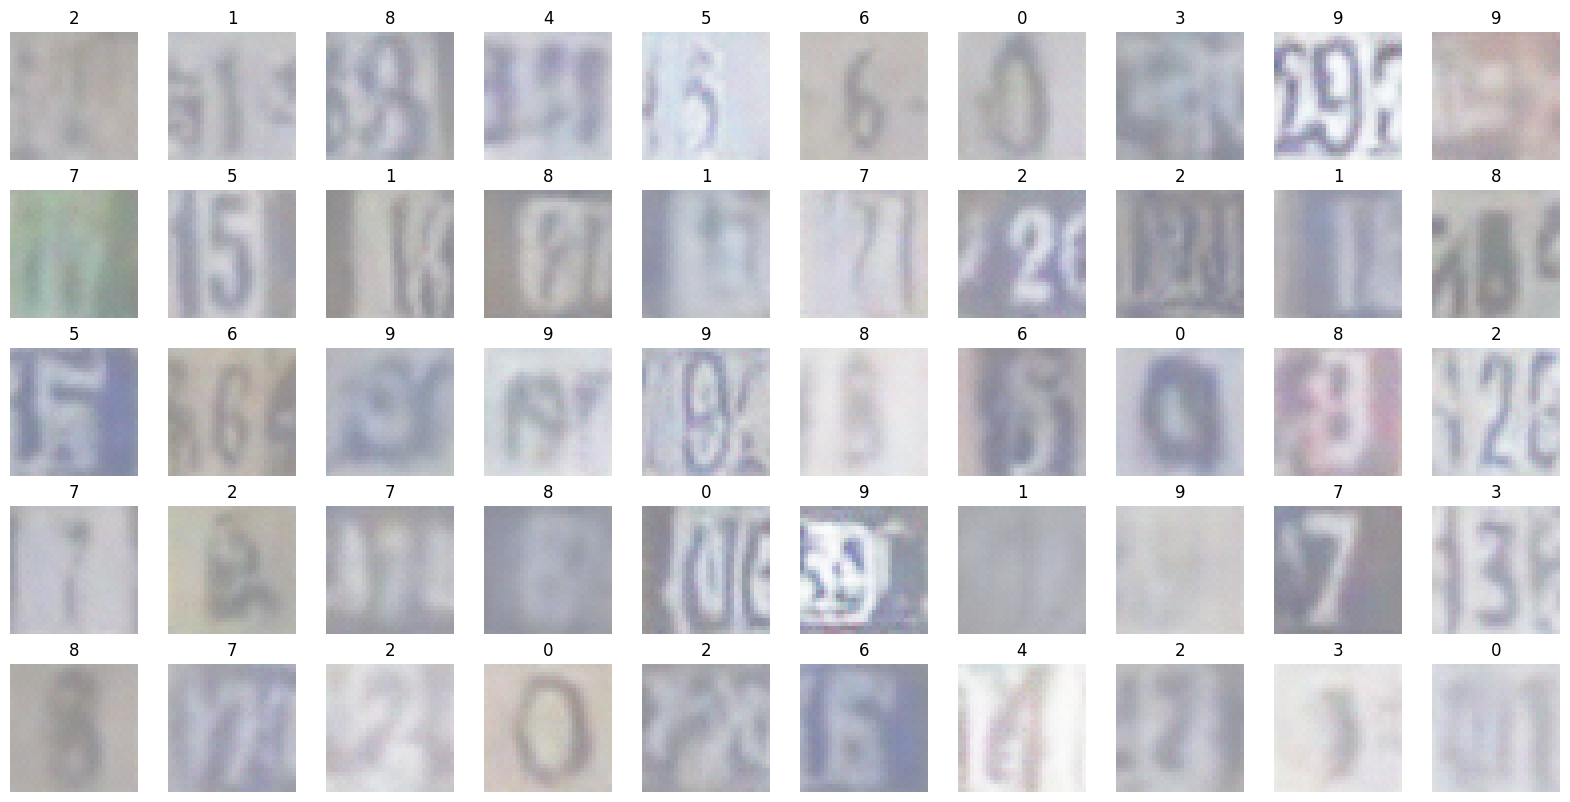

Average time per execution: 0.032765 seconds


In [34]:
LOAD_MODEL = True
eva_gen = Generator()
eva_dis = Discriminator()
if LOAD_MODEL:
    eva_gen.load_state_dict(torch.load(os.path.join(model_path, 'gen.pkl')))
    eva_dis.load_state_dict(torch.load(os.path.join(model_path, 'dis.pkl')))
eva_gen.to(device)
eva_dis.to(device)
num_runs = 10

start_time = time.time()
for _ in range(num_runs):
    gen_images, gen_labels = eva_gen.generate(n_samples=1000, device=device)
end_time = time.time()

plot_samples(gen_images, gen_labels)

average_time = (end_time - start_time) / num_runs
print(f"Average time per execution: {average_time:.6f} seconds")
if device == "cpu":
    print("Running on the CPU can make generating samples slower")
assert average_time <= 3, "Your generator is too slow (takes more than 3s to generate 1000 samples)"